In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pickle
from tqdm import tqdm
from mmcv import Config
from mmcv.runner import load_checkpoint
import cv2
from sklearn.metrics import roc_auc_score

# 필요한 프로젝트 임포트
import sys
sys.path.append('/userHome/userhome4/kyoungmin/code/Xray/CTransCNN')
from model.models import build_classifier

# 저장 디렉토리 설정
BASE_RESULT_DIR = "/userHome/userhome4/kyoungmin/code/Xray/CTransCNN/result/error_analysis_ipynb_version"
os.makedirs(BASE_RESULT_DIR, exist_ok=True)
plots_dir = os.path.join(BASE_RESULT_DIR, "plots")
metrics_dir = os.path.join(BASE_RESULT_DIR, "metrics")
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)

# GPU 설정
device = 'cuda:3'
print(f"Using device: {device}")

# 질병 클래스 정의
disease_labels = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 
                 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 
                 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']


/userHome/userhome4/kyoungmin/miniconda3/envs/ctranscnn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:3


In [ ]:
# 설정 파일 로드
config_file = "/userHome/userhome4/kyoungmin/code/Xray/CTransCNN/configs/NIH_ChestX-ray14_CTransCNN.py"
checkpoint_file = "/userHome/userhome4/kyoungmin/code/Xray/CTransCNN/save/epoch_50.pth"

# 구성 로드
cfg = Config.fromfile(config_file)
print("Model config:", cfg.model.type)

# 모델 빌드 (원본 코드와 동일한 방식)
model = build_classifier(cfg.model)
print(f"Model built: {type(model)}")

# 가중치 로드
checkpoint = load_checkpoint(model, checkpoint_file, map_location='cpu')
print("Checkpoint loaded successfully")

# GPU 설정
model.to(device)
model.eval()
print("Model ready for inference")


Model config: ImageClassifier
Model built: <class 'model.models.classifiers.image.ImageClassifier'>
load checkpoint from local path: /userHome/userhome4/kyoungmin/code/Xray/CTransCNN/save/epoch_30.pth
Checkpoint loaded successfully
Model ready for inference


In [3]:
# 셀 3: 이미지 전처리 및 예측 함수

def preprocess_image(img_path):
    """이미지 전처리 함수"""
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # config에 맞게 수정
    img = img.astype(np.float32) / 255.0  # 정규화
    
    # ImageNet 평균 및 표준편차로 정규화
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean) / std
    
    # 형태 변환 (C, H, W)
    img = np.transpose(img, (2, 0, 1))
    
    # 배치 차원 추가
    img = np.expand_dims(img, axis=0)
    
    # 중요: 명시적으로 float32 데이터 타입 지정
    return torch.tensor(img, dtype=torch.float32)


def predict_single_image(model, img_path):
    """단일 이미지 예측 함수"""
    try:
        # 이미지 전처리
        img_tensor = preprocess_image(img_path)
        img_tensor = img_tensor.to(device)
        
        # 모델 추론
        with torch.no_grad():
            output = model(img_tensor, return_loss=False)
        
        # 출력 형식 확인 및 처리
        if isinstance(output, torch.Tensor):
            probs = torch.sigmoid(output).cpu().numpy()[0]
        elif isinstance(output, tuple):
            probs = torch.sigmoid(output[0]).cpu().numpy()[0]
        else:
            probs = torch.sigmoid(torch.tensor(output, device=device)).cpu().numpy()[0]
        
        return probs
    except Exception as e:
        print(f"Error in prediction: {e}")
        return None


In [4]:
# 셀 4: 테스트 이미지 예측
# 테스트 이미지 목록 로드
test_list_path = "/userHome/userhome4/kyoungmin/code/Xray/dataset/test_list.txt"
with open(test_list_path, 'r') as f:
    test_files = [line.strip() for line in f.readlines()]

print(f"Loaded {len(test_files)} test files")

# NIH 데이터셋 경로
dataset_path = "/userHome/userhome4/kyoungmin/code/Xray/dataset"

# 이미지 디렉토리 탐색
image_dirs = []
for root, dirs, files in os.walk(dataset_path):
    if 'images' in dirs:
        image_dirs.append(os.path.join(root, 'images'))

print(f"Found {len(image_dirs)} image directories: {image_dirs}")

# 샘플 이미지로 테스트 (선택 사항)
if len(image_dirs) > 0 and len(test_files) > 0:
    sample_path = os.path.join(image_dirs[0], test_files[0])
    if os.path.exists(sample_path):
        print(f"Testing with sample image: {sample_path}")
        sample_pred = predict_single_image(model, sample_path)
        print(f"Sample prediction: {sample_pred}")
        print(f"Top predicted diseases: {[disease_labels[i] for i in np.argsort(sample_pred)[-3:][::-1]]}")


Loaded 25596 test files
Found 12 image directories: ['/userHome/userhome4/kyoungmin/code/Xray/dataset/images_005/images', '/userHome/userhome4/kyoungmin/code/Xray/dataset/images_011/images', '/userHome/userhome4/kyoungmin/code/Xray/dataset/images_012/images', '/userHome/userhome4/kyoungmin/code/Xray/dataset/images_003/images', '/userHome/userhome4/kyoungmin/code/Xray/dataset/images_004/images', '/userHome/userhome4/kyoungmin/code/Xray/dataset/images_006/images', '/userHome/userhome4/kyoungmin/code/Xray/dataset/images_002/images', '/userHome/userhome4/kyoungmin/code/Xray/dataset/images_008/images', '/userHome/userhome4/kyoungmin/code/Xray/dataset/images_010/images', '/userHome/userhome4/kyoungmin/code/Xray/dataset/images_001/images', '/userHome/userhome4/kyoungmin/code/Xray/dataset/images_009/images', '/userHome/userhome4/kyoungmin/code/Xray/dataset/images_007/images']


In [5]:
# 셀 5: 전체 테스트셋 예측 및 저장
def load_test_labels(found_images):
    """테스트 레이블 로드 함수"""
    print("Loading test labels...")
    data_path = "/userHome/userhome4/kyoungmin/code/Xray/dataset/Data_Entry_2017.csv"
    
    try:
        labels_df = pd.read_csv(data_path)
        print(f"CSV loaded with shape: {labels_df.shape}")
        print(f"CSV columns: {labels_df.columns.tolist()}")
        
        # 이미지 ID 컬럼과 레이블 컬럼 찾기
        img_col = None
        for col in labels_df.columns:
            if 'Image' in col:
                img_col = col
                break
                
        if img_col is None:
            raise ValueError("Image column not found in CSV")
            
        finding_col = None
        for col in labels_df.columns:
            if 'Finding' in col:
                finding_col = col
                break
                
        if finding_col is None:
            raise ValueError("Finding column not found in CSV")
            
        print(f"Using columns: Image={img_col}, Finding={finding_col}")
        
        # 질병 레이블 원-핫 인코딩
        for disease in disease_labels: 
            labels_df[disease] = labels_df[finding_col].apply(
                lambda x: 1 if disease in str(x) else 0
            )
        
        # 테스트 파일에 대한 레이블 매칭
        test_labels = np.zeros((len(found_images), len(disease_labels)))
        matched_count = 0
        
        for i, img_name in enumerate(found_images):
            # 파일명만 추출
            img_base = os.path.basename(img_name)
            
            # 완전 일치 시도
            match = labels_df[labels_df[img_col] == img_base]
            
            # 일치하지 않으면 부분 일치 시도
            if len(match) == 0:
                match = labels_df[labels_df[img_col].str.contains(img_base, na=False)]
            
            if len(match) > 0:
                matched_count += 1
                row = match.iloc[0]
                for j, disease in enumerate(disease_labels):
                    test_labels[i, j] = row[disease]
        
        print(f"Matched {matched_count}/{len(found_images)} test files with labels")
        return test_labels
        
    except Exception as e:
        print(f"Error loading labels: {e}")
        return np.zeros((len(found_images), len(disease_labels)))

# 예측 결과 파일 확인
prediction_file = os.path.join(BASE_RESULT_DIR, "predictions.pkl")
if os.path.exists(prediction_file):
    print(f"Loading existing predictions from {prediction_file}")
    with open(prediction_file, 'rb') as f:
        saved_results = pickle.load(f)
    
    all_probs = saved_results['probs']
    all_targets = saved_results['targets']
    found_images = saved_results['filenames']
    print(f"Loaded predictions for {len(all_probs)} images")
else:
    print("Running new predictions on test set...")
    all_probs = []
    found_images = []
    
    # 이미지 로드 및 예측
    for i, filename in enumerate(tqdm(test_files)):
        if i % 100 == 0:
            print(f"Processing {i+1}/{len(test_files)}")
            
        # 이미지 파일 찾기
        img_path = None
        for img_dir in image_dirs:
            candidate_path = os.path.join(img_dir, filename)
            if os.path.exists(candidate_path):
                img_path = candidate_path
                break
        
        if img_path is None:
            print(f"Warning: Image {filename} not found")
            continue
            
        # 이미지 예측
        pred = predict_single_image(model, img_path)
        if pred is not None:
            all_probs.append(pred)
            found_images.append(filename)
    
    all_probs = np.array(all_probs)
    print(f"Made predictions for {len(all_probs)} images")
    
    # 테스트 레이블 로드
    all_targets = load_test_labels(found_images)
    
    # 결과 저장
    with open(prediction_file, 'wb') as f:
        pickle.dump({
            'probs': all_probs,
            'targets': all_targets,
            'filenames': found_images,
            'disease_labels': disease_labels
        }, f)
    
    print(f"Saved predictions to {prediction_file}")


Running new predictions on test set...


  0%|          | 0/25596 [00:00<?, ?it/s]

Processing 1/25596


/userHome/userhome4/kyoungmin/miniconda3/envs/ctranscnn/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/tmp/ipykernel_517231/2436268393.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  probs = torch.sigmoid(torch.tensor(output, device=device)).cpu().numpy()[0]
  0%|          | 102/25596 [00:07<19:45, 21.50it/s] 

Processing 101/25596


  1%|          | 203/25596 [00:12<21:58, 19.26it/s]

Processing 201/25596


  1%|          | 302/25596 [00:17<22:32, 18.70it/s]

Processing 301/25596


  2%|▏         | 403/25596 [00:23<22:32, 18.63it/s]  

Processing 401/25596


  2%|▏         | 502/25596 [00:28<20:43, 20.18it/s]

Processing 501/25596


  2%|▏         | 602/25596 [00:33<22:59, 18.12it/s]

Processing 601/25596


  3%|▎         | 704/25596 [00:38<20:25, 20.31it/s]

Processing 701/25596


  3%|▎         | 800/25596 [01:33<1:46:42,  3.87it/s]

Processing 801/25596


  4%|▎         | 900/25596 [02:35<2:08:10,  3.21it/s]

Processing 901/25596


  4%|▍         | 1000/25596 [03:46<3:31:18,  1.94it/s]

Processing 1001/25596


  4%|▍         | 1100/25596 [04:41<2:56:22,  2.31it/s]

Processing 1101/25596


  5%|▍         | 1201/25596 [05:19<21:14, 19.15it/s]  

Processing 1201/25596


  5%|▌         | 1301/25596 [05:28<34:01, 11.90it/s]

Processing 1301/25596


  5%|▌         | 1401/25596 [05:48<3:30:58,  1.91it/s]

Processing 1401/25596


  6%|▌         | 1502/25596 [06:04<1:05:47,  6.10it/s]

Processing 1501/25596


  6%|▋         | 1602/25596 [06:30<1:14:32,  5.37it/s]

Processing 1601/25596


  7%|▋         | 1703/25596 [06:42<24:54, 15.98it/s]  

Processing 1701/25596


  7%|▋         | 1804/25596 [06:48<27:33, 14.39it/s]

Processing 1801/25596


  7%|▋         | 1902/25596 [06:56<35:40, 11.07it/s]  

Processing 1901/25596


  8%|▊         | 2000/25596 [07:43<2:09:52,  3.03it/s] 

Processing 2001/25596


  8%|▊         | 2101/25596 [08:14<1:15:44,  5.17it/s]

Processing 2101/25596


  9%|▊         | 2202/25596 [08:52<3:53:23,  1.67it/s]

Processing 2201/25596


  9%|▉         | 2300/25596 [09:38<2:36:49,  2.48it/s]

Processing 2301/25596


  9%|▉         | 2402/25596 [10:11<21:57, 17.60it/s]   

Processing 2401/25596


 10%|▉         | 2502/25596 [10:21<47:25,  8.12it/s]  

Processing 2501/25596


 10%|█         | 2602/25596 [10:37<46:44,  8.20it/s]  

Processing 2601/25596


 11%|█         | 2702/25596 [10:46<37:09, 10.27it/s]  

Processing 2701/25596


 11%|█         | 2803/25596 [10:55<27:02, 14.04it/s]

Processing 2801/25596


 11%|█▏        | 2901/25596 [11:06<30:24, 12.44it/s]  

Processing 2901/25596


 12%|█▏        | 3000/25596 [11:27<1:32:57,  4.05it/s]

Processing 3001/25596


 12%|█▏        | 3102/25596 [11:41<37:19, 10.04it/s]  

Processing 3101/25596


 13%|█▎        | 3203/25596 [11:51<30:38, 12.18it/s]  

Processing 3201/25596


 13%|█▎        | 3303/25596 [12:17<54:52,  6.77it/s]  

Processing 3301/25596


 13%|█▎        | 3401/25596 [12:45<2:36:44,  2.36it/s]

Processing 3401/25596


 14%|█▎        | 3500/25596 [13:02<36:19, 10.14it/s]  

Processing 3501/25596


 14%|█▍        | 3602/25596 [13:10<25:22, 14.45it/s]

Processing 3601/25596


 14%|█▍        | 3702/25596 [13:26<1:13:05,  4.99it/s]

Processing 3701/25596


 15%|█▍        | 3800/25596 [13:57<38:37,  9.41it/s]  

Processing 3801/25596


 15%|█▌        | 3901/25596 [14:33<1:34:30,  3.83it/s]

Processing 3901/25596


 16%|█▌        | 4001/25596 [14:44<32:06, 11.21it/s]  

Processing 4001/25596


 16%|█▌        | 4100/25596 [15:05<1:57:21,  3.05it/s]

Processing 4101/25596


 16%|█▋        | 4200/25596 [15:48<3:20:31,  1.78it/s]

Processing 4201/25596


 17%|█▋        | 4300/25596 [16:22<1:11:50,  4.94it/s]

Processing 4301/25596


 17%|█▋        | 4400/25596 [16:55<1:47:23,  3.29it/s]

Processing 4401/25596


 18%|█▊        | 4502/25596 [17:22<46:31,  7.56it/s]  

Processing 4501/25596


 18%|█▊        | 4599/25596 [17:40<1:18:20,  4.47it/s]

Processing 4601/25596


 18%|█▊        | 4701/25596 [18:03<1:16:00,  4.58it/s]

Processing 4701/25596


 19%|█▉        | 4802/25596 [18:24<54:50,  6.32it/s]  

Processing 4801/25596


 19%|█▉        | 4901/25596 [18:37<34:39,  9.95it/s]  

Processing 4901/25596


 20%|█▉        | 5001/25596 [18:48<56:44,  6.05it/s]  

Processing 5001/25596


 20%|█▉        | 5100/25596 [19:04<55:37,  6.14it/s]  

Processing 5101/25596


 20%|██        | 5199/25596 [19:22<46:26,  7.32it/s]  

Processing 5201/25596


 21%|██        | 5301/25596 [19:31<26:36, 12.72it/s]

Processing 5301/25596


 21%|██        | 5402/25596 [19:40<29:26, 11.43it/s]  

Processing 5401/25596


 21%|██▏       | 5499/25596 [19:49<35:45,  9.37it/s]

Processing 5501/25596


 22%|██▏       | 5602/25596 [20:07<31:46, 10.49it/s]  

Processing 5601/25596


 22%|██▏       | 5702/25596 [20:19<24:59, 13.26it/s]  

Processing 5701/25596


 23%|██▎       | 5803/25596 [20:30<34:22,  9.60it/s]  

Processing 5801/25596


 23%|██▎       | 5902/25596 [20:47<35:07,  9.34it/s]  

Processing 5901/25596


 23%|██▎       | 6000/25596 [21:13<1:53:16,  2.88it/s]

Processing 6001/25596


 24%|██▍       | 6103/25596 [21:29<21:57, 14.79it/s]  

Processing 6101/25596


 24%|██▍       | 6201/25596 [21:35<25:18, 12.77it/s]

Processing 6201/25596


 25%|██▍       | 6300/25596 [21:50<1:32:07,  3.49it/s]

Processing 6301/25596


 25%|██▌       | 6403/25596 [22:27<1:02:36,  5.11it/s]

Processing 6401/25596


 25%|██▌       | 6500/25596 [23:01<1:18:17,  4.07it/s]

Processing 6501/25596


 26%|██▌       | 6601/25596 [23:27<1:29:42,  3.53it/s]

Processing 6601/25596


 26%|██▌       | 6702/25596 [23:52<2:01:10,  2.60it/s]

Processing 6701/25596


 27%|██▋       | 6800/25596 [24:21<39:07,  8.01it/s]  

Processing 6801/25596


 27%|██▋       | 6899/25596 [24:41<1:28:57,  3.50it/s]

Processing 6901/25596


 27%|██▋       | 7002/25596 [25:08<24:29, 12.66it/s]  

Processing 7001/25596


 28%|██▊       | 7099/25596 [25:17<29:08, 10.58it/s]

Processing 7101/25596


 28%|██▊       | 7201/25596 [25:38<1:26:33,  3.54it/s]

Processing 7201/25596


 29%|██▊       | 7301/25596 [25:55<23:17, 13.09it/s]  

Processing 7301/25596


 29%|██▉       | 7400/25596 [26:04<53:42,  5.65it/s]

Processing 7401/25596


 29%|██▉       | 7500/25596 [26:25<1:01:17,  4.92it/s]

Processing 7501/25596


 30%|██▉       | 7603/25596 [26:37<21:48, 13.75it/s]  

Processing 7601/25596


 30%|███       | 7701/25596 [26:42<14:47, 20.16it/s]

Processing 7701/25596


 30%|███       | 7801/25596 [26:48<20:18, 14.61it/s]

Processing 7801/25596


 31%|███       | 7901/25596 [26:59<46:18,  6.37it/s]  

Processing 7901/25596


 31%|███▏      | 8000/25596 [27:19<40:22,  7.26it/s]  

Processing 8001/25596


 32%|███▏      | 8101/25596 [27:42<50:38,  5.76it/s]  

Processing 8101/25596


 32%|███▏      | 8201/25596 [28:03<1:20:06,  3.62it/s]

Processing 8201/25596


 32%|███▏      | 8300/25596 [28:27<2:11:50,  2.19it/s]

Processing 8301/25596


 33%|███▎      | 8401/25596 [28:47<32:43,  8.76it/s]  

Processing 8401/25596


 33%|███▎      | 8501/25596 [29:09<49:04,  5.81it/s]  

Processing 8501/25596


 34%|███▎      | 8601/25596 [29:30<59:39,  4.75it/s]  

Processing 8601/25596


 34%|███▍      | 8700/25596 [29:48<46:20,  6.08it/s]  

Processing 8701/25596


 34%|███▍      | 8800/25596 [30:14<1:02:56,  4.45it/s]

Processing 8801/25596


 35%|███▍      | 8903/25596 [30:46<52:52,  5.26it/s]  

Processing 8901/25596


 35%|███▌      | 9001/25596 [31:21<1:00:21,  4.58it/s]

Processing 9001/25596


 36%|███▌      | 9102/25596 [31:45<46:10,  5.95it/s]  

Processing 9101/25596


 36%|███▌      | 9201/25596 [32:08<34:53,  7.83it/s]  

Processing 9201/25596


 36%|███▋      | 9302/25596 [33:00<31:52,  8.52it/s]  

Processing 9301/25596


 37%|███▋      | 9402/25596 [33:36<30:59,  8.71it/s]  

Processing 9401/25596


 37%|███▋      | 9501/25596 [33:44<25:38, 10.46it/s]

Processing 9501/25596


 38%|███▊      | 9600/25596 [34:04<2:24:30,  1.84it/s]

Processing 9601/25596


 38%|███▊      | 9702/25596 [34:38<35:51,  7.39it/s]  

Processing 9701/25596


 38%|███▊      | 9799/25596 [34:59<58:29,  4.50it/s]  

Processing 9801/25596


 39%|███▊      | 9899/25596 [35:24<40:16,  6.50it/s]  

Processing 9901/25596


 39%|███▉      | 10000/25596 [35:43<54:34,  4.76it/s] 

Processing 10001/25596


 39%|███▉      | 10101/25596 [36:03<27:34,  9.37it/s]  

Processing 10101/25596


 40%|███▉      | 10201/25596 [36:15<18:51, 13.60it/s]  

Processing 10201/25596


 40%|████      | 10303/25596 [36:24<13:56, 18.28it/s]

Processing 10301/25596


 41%|████      | 10402/25596 [36:30<13:58, 18.12it/s]

Processing 10401/25596


 41%|████      | 10502/25596 [36:38<16:26, 15.30it/s]

Processing 10501/25596


 41%|████▏     | 10601/25596 [36:57<47:56,  5.21it/s]  

Processing 10601/25596


 42%|████▏     | 10702/25596 [37:14<52:36,  4.72it/s]  

Processing 10701/25596


 42%|████▏     | 10800/25596 [37:38<35:18,  6.99it/s]  

Processing 10801/25596


 43%|████▎     | 10902/25596 [37:54<51:07,  4.79it/s]  

Processing 10901/25596


 43%|████▎     | 11002/25596 [38:23<1:34:42,  2.57it/s]

Processing 11001/25596


 43%|████▎     | 11103/25596 [38:36<14:21, 16.82it/s]  

Processing 11101/25596


 44%|████▍     | 11200/25596 [38:42<15:27, 15.53it/s]

Processing 11201/25596


 44%|████▍     | 11300/25596 [38:59<1:29:44,  2.65it/s]

Processing 11301/25596


 45%|████▍     | 11400/25596 [39:28<21:33, 10.97it/s]  

Processing 11401/25596


 45%|████▍     | 11499/25596 [39:43<27:58,  8.40it/s]  

Processing 11501/25596


 45%|████▌     | 11600/25596 [40:05<59:54,  3.89it/s]  

Processing 11601/25596


 46%|████▌     | 11700/25596 [40:31<32:39,  7.09it/s]  

Processing 11701/25596


 46%|████▌     | 11801/25596 [40:43<21:25, 10.73it/s]  

Processing 11801/25596


 47%|████▋     | 11903/25596 [40:52<13:35, 16.78it/s]

Processing 11901/25596


 47%|████▋     | 12000/25596 [40:59<15:23, 14.72it/s]

Processing 12001/25596


 47%|████▋     | 12099/25596 [41:21<41:19,  5.44it/s]  

Processing 12101/25596


 48%|████▊     | 12200/25596 [42:23<1:23:08,  2.69it/s]

Processing 12201/25596


 48%|████▊     | 12300/25596 [42:48<41:01,  5.40it/s]  

Processing 12301/25596


 48%|████▊     | 12399/25596 [43:08<42:55,  5.12it/s]  

Processing 12401/25596


 49%|████▉     | 12502/25596 [43:34<30:28,  7.16it/s]  

Processing 12501/25596


 49%|████▉     | 12600/25596 [43:49<1:04:40,  3.35it/s]

Processing 12601/25596


 50%|████▉     | 12701/25596 [44:09<50:41,  4.24it/s]  

Processing 12701/25596


 50%|█████     | 12801/25596 [44:28<20:45, 10.28it/s]  

Processing 12801/25596


 50%|█████     | 12902/25596 [44:50<22:58,  9.21it/s]  

Processing 12901/25596


 51%|█████     | 13003/25596 [44:58<13:02, 16.10it/s]

Processing 13001/25596


 51%|█████     | 13100/25596 [45:05<14:14, 14.63it/s]

Processing 13101/25596


 52%|█████▏    | 13202/25596 [45:21<34:05,  6.06it/s]  

Processing 13201/25596


 52%|█████▏    | 13302/25596 [46:03<48:20,  4.24it/s]  

Processing 13301/25596


 52%|█████▏    | 13402/25596 [46:18<11:53, 17.08it/s]  

Processing 13401/25596


 53%|█████▎    | 13502/25596 [46:23<10:39, 18.90it/s]

Processing 13501/25596


 53%|█████▎    | 13603/25596 [46:29<11:35, 17.25it/s]

Processing 13601/25596


 54%|█████▎    | 13700/25596 [46:41<28:49,  6.88it/s]

Processing 13701/25596


 54%|█████▍    | 13801/25596 [47:02<38:00,  5.17it/s]  

Processing 13801/25596


 54%|█████▍    | 13900/25596 [47:19<2:24:22,  1.35it/s]

Processing 13901/25596


 55%|█████▍    | 14000/25596 [48:08<1:19:50,  2.42it/s]

Processing 14001/25596


 55%|█████▌    | 14102/25596 [48:36<24:11,  7.92it/s]  

Processing 14101/25596


 55%|█████▌    | 14202/25596 [48:53<32:57,  5.76it/s]

Processing 14201/25596


 56%|█████▌    | 14300/25596 [49:27<18:45, 10.04it/s]  

Processing 14301/25596


 56%|█████▋    | 14399/25596 [49:51<2:52:32,  1.08it/s]

Processing 14401/25596


 57%|█████▋    | 14500/25596 [50:08<18:13, 10.15it/s]  

Processing 14501/25596


 57%|█████▋    | 14601/25596 [50:23<45:31,  4.02it/s]  

Processing 14601/25596


 57%|█████▋    | 14699/25596 [50:50<42:10,  4.31it/s]  

Processing 14701/25596


 58%|█████▊    | 14801/25596 [50:59<09:27, 19.01it/s]

Processing 14801/25596


 58%|█████▊    | 14902/25596 [51:04<10:39, 16.72it/s]

Processing 14901/25596


 59%|█████▊    | 15002/25596 [51:10<12:26, 14.19it/s]

Processing 15001/25596


 59%|█████▉    | 15100/25596 [51:24<40:51,  4.28it/s]

Processing 15101/25596


 59%|█████▉    | 15199/25596 [51:49<27:50,  6.22it/s]  

Processing 15201/25596


 60%|█████▉    | 15301/25596 [52:08<22:46,  7.53it/s]  

Processing 15301/25596


 60%|██████    | 15399/25596 [52:24<57:54,  2.93it/s]

Processing 15401/25596


 61%|██████    | 15500/25596 [52:59<1:08:20,  2.46it/s]

Processing 15501/25596


 61%|██████    | 15602/25596 [53:16<10:41, 15.57it/s]  

Processing 15601/25596


 61%|██████▏   | 15701/25596 [53:24<17:31,  9.41it/s]

Processing 15701/25596


 62%|██████▏   | 15802/25596 [53:39<1:01:29,  2.65it/s]

Processing 15801/25596


 62%|██████▏   | 15901/25596 [53:58<13:12, 12.23it/s]  

Processing 15901/25596


 63%|██████▎   | 16001/25596 [54:05<09:31, 16.80it/s]

Processing 16001/25596


 63%|██████▎   | 16102/25596 [54:14<19:59,  7.92it/s]

Processing 16101/25596


 63%|██████▎   | 16200/25596 [54:44<1:37:06,  1.61it/s]

Processing 16201/25596


 64%|██████▎   | 16302/25596 [55:13<17:38,  8.78it/s]  

Processing 16301/25596


 64%|██████▍   | 16402/25596 [55:29<17:37,  8.69it/s]

Processing 16401/25596


 64%|██████▍   | 16500/25596 [55:36<14:54, 10.17it/s]

Processing 16501/25596


 65%|██████▍   | 16600/25596 [55:53<29:08,  5.15it/s]

Processing 16601/25596


 65%|██████▌   | 16702/25596 [56:08<12:00, 12.34it/s]

Processing 16701/25596


 66%|██████▌   | 16804/25596 [56:15<07:28, 19.62it/s]

Processing 16801/25596


 66%|██████▌   | 16903/25596 [56:21<09:14, 15.67it/s]

Processing 16901/25596


 66%|██████▋   | 17000/25596 [56:40<29:19,  4.89it/s]  

Processing 17001/25596


 67%|██████▋   | 17101/25596 [57:24<41:44,  3.39it/s]  

Processing 17101/25596


 67%|██████▋   | 17202/25596 [58:00<17:37,  7.94it/s]  

Processing 17201/25596


 68%|██████▊   | 17301/25596 [58:21<13:12, 10.47it/s]  

Processing 17301/25596


 68%|██████▊   | 17401/25596 [58:30<08:29, 16.10it/s]

Processing 17401/25596


 68%|██████▊   | 17499/25596 [58:50<14:12,  9.49it/s]  

Processing 17501/25596


 69%|██████▉   | 17602/25596 [59:19<30:19,  4.39it/s]  

Processing 17601/25596


 69%|██████▉   | 17701/25596 [59:43<24:56,  5.28it/s]  

Processing 17701/25596


 70%|██████▉   | 17800/25596 [1:00:08<57:27,  2.26it/s]

Processing 17801/25596


 70%|██████▉   | 17900/25596 [1:00:38<22:46,  5.63it/s]  

Processing 17901/25596


 70%|███████   | 18000/25596 [1:01:09<23:58,  5.28it/s]  

Processing 18001/25596


 71%|███████   | 18101/25596 [1:01:40<30:11,  4.14it/s]  

Processing 18101/25596


 71%|███████   | 18199/25596 [1:02:05<33:42,  3.66it/s]  

Processing 18201/25596


 71%|███████▏  | 18300/25596 [1:02:29<28:12,  4.31it/s]  

Processing 18301/25596


 72%|███████▏  | 18401/25596 [1:02:56<14:47,  8.11it/s]  

Processing 18401/25596


 72%|███████▏  | 18500/25596 [1:03:17<25:41,  4.60it/s]

Processing 18501/25596


 73%|███████▎  | 18602/25596 [1:03:40<21:20,  5.46it/s]

Processing 18601/25596


 73%|███████▎  | 18700/25596 [1:03:59<18:03,  6.37it/s]

Processing 18701/25596


 73%|███████▎  | 18802/25596 [1:04:26<15:42,  7.21it/s]

Processing 18801/25596


 74%|███████▍  | 18902/25596 [1:04:55<35:27,  3.15it/s]  

Processing 18901/25596


 74%|███████▍  | 19001/25596 [1:05:26<28:06,  3.91it/s]

Processing 19001/25596


 75%|███████▍  | 19101/25596 [1:06:09<32:53,  3.29it/s]  

Processing 19101/25596


 75%|███████▌  | 19200/25596 [1:06:56<20:17,  5.25it/s]  

Processing 19201/25596


 75%|███████▌  | 19300/25596 [1:07:14<12:15,  8.56it/s]

Processing 19301/25596


 76%|███████▌  | 19402/25596 [1:07:23<08:21, 12.35it/s]

Processing 19401/25596


 76%|███████▌  | 19501/25596 [1:07:30<07:28, 13.59it/s]

Processing 19501/25596


 77%|███████▋  | 19600/25596 [1:07:43<14:08,  7.07it/s]

Processing 19601/25596


 77%|███████▋  | 19701/25596 [1:08:05<12:46,  7.69it/s]

Processing 19701/25596


 77%|███████▋  | 19800/25596 [1:08:31<12:41,  7.61it/s]

Processing 19801/25596


 78%|███████▊  | 19899/25596 [1:09:01<27:04,  3.51it/s]

Processing 19901/25596


 78%|███████▊  | 20000/25596 [1:09:36<22:56,  4.07it/s]  

Processing 20001/25596


 79%|███████▊  | 20100/25596 [1:10:03<16:01,  5.72it/s]

Processing 20101/25596


 79%|███████▉  | 20202/25596 [1:10:23<09:49,  9.15it/s]

Processing 20201/25596


 79%|███████▉  | 20302/25596 [1:10:37<08:28, 10.42it/s]

Processing 20301/25596


 80%|███████▉  | 20400/25596 [1:10:54<11:32,  7.50it/s]

Processing 20401/25596


 80%|████████  | 20500/25596 [1:11:25<14:55,  5.69it/s]  

Processing 20501/25596


 80%|████████  | 20599/25596 [1:11:40<10:40,  7.80it/s]

Processing 20601/25596


 81%|████████  | 20701/25596 [1:11:54<11:40,  6.99it/s]

Processing 20701/25596


 81%|████████▏ | 20803/25596 [1:12:02<05:24, 14.76it/s]

Processing 20801/25596


 82%|████████▏ | 20903/25596 [1:12:10<05:21, 14.59it/s]

Processing 20901/25596


 82%|████████▏ | 20999/25596 [1:12:21<08:15,  9.28it/s]

Processing 21001/25596


 82%|████████▏ | 21102/25596 [1:12:39<10:06,  7.41it/s]

Processing 21101/25596


 83%|████████▎ | 21200/25596 [1:12:57<17:53,  4.10it/s]

Processing 21201/25596


 83%|████████▎ | 21300/25596 [1:13:19<18:43,  3.82it/s]

Processing 21301/25596


 84%|████████▎ | 21401/25596 [1:13:43<20:57,  3.34it/s]

Processing 21401/25596


 84%|████████▍ | 21501/25596 [1:13:59<09:10,  7.44it/s]

Processing 21501/25596


 84%|████████▍ | 21601/25596 [1:14:12<09:32,  6.98it/s]

Processing 21601/25596


 85%|████████▍ | 21701/25596 [1:14:25<07:13,  8.99it/s]

Processing 21701/25596


 85%|████████▌ | 21801/25596 [1:14:48<10:07,  6.25it/s]

Processing 21801/25596


 86%|████████▌ | 21900/25596 [1:15:15<23:20,  2.64it/s]

Processing 21901/25596


 86%|████████▌ | 21999/25596 [1:15:36<09:51,  6.08it/s]

Processing 22001/25596


 86%|████████▋ | 22101/25596 [1:15:59<19:20,  3.01it/s]

Processing 22101/25596


 87%|████████▋ | 22201/25596 [1:16:35<08:36,  6.57it/s]

Processing 22201/25596


 87%|████████▋ | 22300/25596 [1:17:03<18:53,  2.91it/s]

Processing 22301/25596


 88%|████████▊ | 22399/25596 [1:17:34<11:02,  4.83it/s]

Processing 22401/25596


 88%|████████▊ | 22500/25596 [1:17:52<11:58,  4.31it/s]

Processing 22501/25596


 88%|████████▊ | 22600/25596 [1:18:11<11:27,  4.36it/s]

Processing 22601/25596


 89%|████████▊ | 22700/25596 [1:18:41<16:35,  2.91it/s]

Processing 22701/25596


 89%|████████▉ | 22800/25596 [1:18:59<07:25,  6.28it/s]

Processing 22801/25596


 89%|████████▉ | 22900/25596 [1:19:18<04:43,  9.49it/s]

Processing 22901/25596


 90%|████████▉ | 23001/25596 [1:19:33<06:31,  6.62it/s]

Processing 23001/25596


 90%|█████████ | 23101/25596 [1:19:50<06:57,  5.97it/s]

Processing 23101/25596


 91%|█████████ | 23201/25596 [1:20:06<05:08,  7.77it/s]

Processing 23201/25596


 91%|█████████ | 23302/25596 [1:20:19<06:07,  6.24it/s]

Processing 23301/25596


 91%|█████████▏| 23401/25596 [1:20:35<05:44,  6.38it/s]

Processing 23401/25596


 92%|█████████▏| 23502/25596 [1:20:51<03:36,  9.66it/s]

Processing 23501/25596


 92%|█████████▏| 23603/25596 [1:21:01<01:51, 17.83it/s]

Processing 23601/25596


 93%|█████████▎| 23703/25596 [1:21:08<01:46, 17.73it/s]

Processing 23701/25596


 93%|█████████▎| 23802/25596 [1:21:14<01:56, 15.42it/s]

Processing 23801/25596


 93%|█████████▎| 23901/25596 [1:21:23<02:59,  9.46it/s]

Processing 23901/25596


 94%|█████████▍| 24000/25596 [1:21:47<16:40,  1.59it/s]

Processing 24001/25596


 94%|█████████▍| 24100/25596 [1:22:20<05:22,  4.64it/s]

Processing 24101/25596


 95%|█████████▍| 24200/25596 [1:22:46<03:25,  6.78it/s]

Processing 24201/25596


 95%|█████████▍| 24300/25596 [1:23:04<03:46,  5.72it/s]

Processing 24301/25596


 95%|█████████▌| 24401/25596 [1:23:29<09:51,  2.02it/s]

Processing 24401/25596


 96%|█████████▌| 24501/25596 [1:23:50<02:38,  6.91it/s]

Processing 24501/25596


 96%|█████████▌| 24601/25596 [1:23:59<01:14, 13.41it/s]

Processing 24601/25596


 97%|█████████▋| 24701/25596 [1:24:07<01:01, 14.56it/s]

Processing 24701/25596


 97%|█████████▋| 24802/25596 [1:24:14<01:03, 12.41it/s]

Processing 24801/25596


 97%|█████████▋| 24901/25596 [1:24:27<03:02,  3.82it/s]

Processing 24901/25596


 98%|█████████▊| 25001/25596 [1:24:46<01:20,  7.41it/s]

Processing 25001/25596


 98%|█████████▊| 25099/25596 [1:25:07<01:49,  4.55it/s]

Processing 25101/25596


 98%|█████████▊| 25200/25596 [1:25:33<02:08,  3.07it/s]

Processing 25201/25596


 99%|█████████▉| 25301/25596 [1:26:00<01:19,  3.70it/s]

Processing 25301/25596


 99%|█████████▉| 25401/25596 [1:26:26<00:47,  4.10it/s]

Processing 25401/25596


100%|█████████▉| 25500/25596 [1:26:52<00:14,  6.64it/s]

Processing 25501/25596


100%|██████████| 25596/25596 [1:27:15<00:00,  4.89it/s]


Made predictions for 25596 images
Loading test labels...
CSV loaded with shape: (112120, 12)
CSV columns: ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']
Using columns: Image=Image Index, Finding=Finding Labels
Matched 25596/25596 test files with labels
Saved predictions to /userHome/userhome4/kyoungmin/code/Xray/CTransCNN/result/error_analysis_ipynb_version/predictions.pkl


In [6]:
# 셀 6: 오류 계산 및 분석

def calculate_sample_errors(probs, targets):
    """
    교수님 지시에 따라 각 샘플의 오류 크기 계산:
    - 정답이 0인데 예측이 양수 -> 오류 = 예측값
    - 정답이 1인데 예측이 음수 -> 오류 = 1-예측값
    """
    n_samples = probs.shape[0]
    n_classes = probs.shape[1]
    
    # logit값으로 변환 (시그모이드 역변환)
    epsilon = 1e-7  # 수치 안정성을 위한 작은 값
    logits = np.log((probs + epsilon) / (1 - probs + epsilon))
    
    sample_errors = []
    
    for i in range(n_samples):
        errors = []
        
        for c in range(n_classes):
            true_label = targets[i, c]
            net_value = logits[i, c]
            
            if true_label == 0:
                # 정답이 0일 때, 양수 net value가 오류
                error = max(0, net_value)
            else:
                # 정답이 1일 때, 음수 net value가 오류 (절대값 적용)
                error = max(0, -net_value)
            
            errors.append(error)
        
        # 샘플의 전체 오류 = 각 클래스 오류의 평균
        sample_errors.append(np.mean(errors))
    
    return np.array(sample_errors)

# 오류 계산
sample_errors = calculate_sample_errors(all_probs, all_targets)

# 상위 오류 샘플 분석
sorted_indices = np.argsort(sample_errors)[::-1]  # 내림차순 정렬
top_20_percent = int(len(sorted_indices) * 0.2)
high_error_indices = sorted_indices[:top_20_percent]

print(f"Analyzed {len(sample_errors)} samples")
print(f"Top error score: {sample_errors[sorted_indices[0]]:.4f}")
print(f"Median error score: {np.median(sample_errors):.4f}")
print(f"Extracted top {top_20_percent} samples with highest errors")


Analyzed 25596 samples
Top error score: 0.3440
Median error score: 0.2066
Extracted top 5119 samples with highest errors


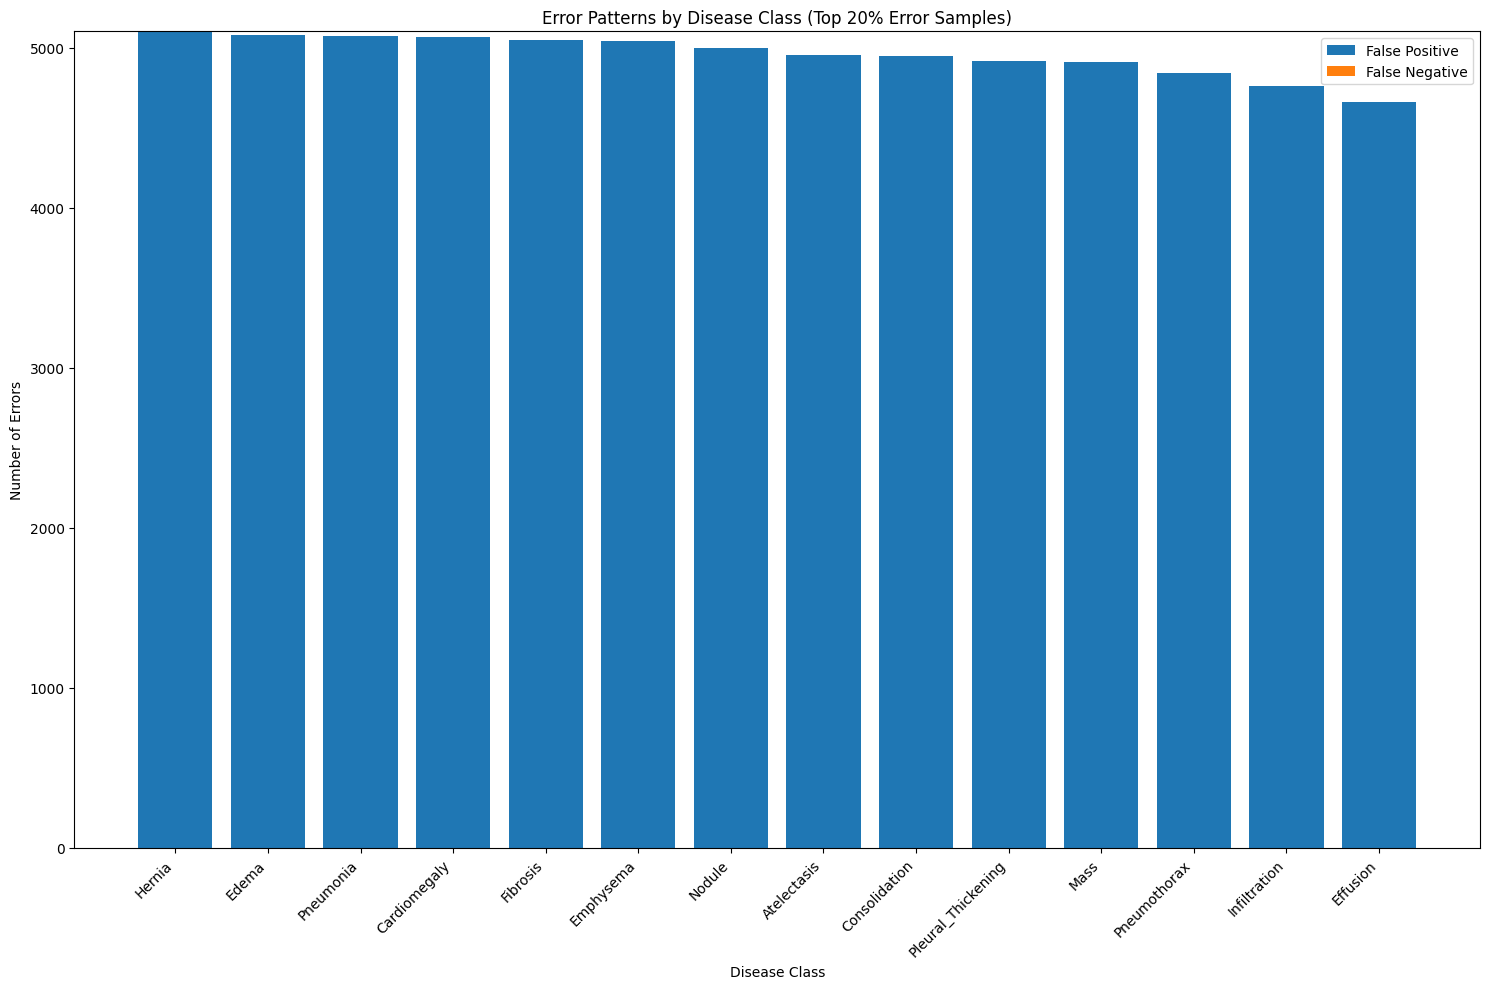

✅ Error analysis saved to '/userHome/userhome4/kyoungmin/code/Xray/CTransCNN/result/error_analysis_ipynb_version/plots/ctranscnn_error_patterns.png' and '/userHome/userhome4/kyoungmin/code/Xray/CTransCNN/result/error_analysis_ipynb_version/metrics/ctranscnn_high_error_samples.csv'


In [7]:
# 셀 7: 오류 시각화 및 메트릭 계산

# 이진 예측값 생성
binary_preds = (all_probs >= 0.5).astype(int)

# 클래스별 오류 패턴 분석
class_error_counts = {cls: 0 for cls in disease_labels}
false_positives = {cls: 0 for cls in disease_labels}
false_negatives = {cls: 0 for cls in disease_labels}

for idx in high_error_indices:
    for c, cls_name in enumerate(disease_labels):
        true_label = all_targets[idx, c]
        pred_label = binary_preds[idx, c]
        
        if pred_label != true_label:
            class_error_counts[cls_name] += 1
            
            if true_label == 0 and pred_label == 1:
                false_positives[cls_name] += 1
            elif true_label == 1 and pred_label == 0:
                false_negatives[cls_name] += 1

# 오류 패턴 시각화
plt.figure(figsize=(15, 10))

# 총 오류 수 기준 클래스 정렬
sorted_classes = sorted(class_error_counts.items(), key=lambda x: x[1], reverse=True)
sorted_class_names = [item[0] for item in sorted_classes]

# 거짓 양성과 거짓 음성 데이터 준비
fp_data = [false_positives[cls] for cls in sorted_class_names]
fn_data = [false_negatives[cls] for cls in sorted_class_names]

# 누적 막대 그래프 그리기
bar_width = 0.8
plt.bar(sorted_class_names, fp_data, bar_width, label='False Positive')
plt.bar(sorted_class_names, fn_data, bar_width, bottom=fp_data, label='False Negative')

plt.xlabel('Disease Class')
plt.ylabel('Number of Errors')
plt.title('Error Patterns by Disease Class (Top 20% Error Samples)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# 그래프 저장
error_plot_file = os.path.join(plots_dir, "ctranscnn_error_patterns.png")
plt.savefig(error_plot_file)
plt.show()

# 상위 20% 오류 샘플 정보 저장
high_error_df = pd.DataFrame({
    'Index': high_error_indices,
    'Filename': [found_images[i] for i in high_error_indices],
    'Error_Score': sample_errors[high_error_indices]
})

for i, cls in enumerate(disease_labels):
    high_error_df[f'True_{cls}'] = [all_targets[idx, i] for idx in high_error_indices]
    high_error_df[f'Pred_{cls}'] = [all_probs[idx, i] for idx in high_error_indices]

high_error_file = os.path.join(metrics_dir, "ctranscnn_high_error_samples.csv")
high_error_df.to_csv(high_error_file)

print(f"✅ Error analysis saved to '{error_plot_file}' and '{high_error_file}'")


In [8]:
# 셀 8: 다중 레이블 분류 지표 계산

# 다중 레이블 분류 지표 계산 함수
def hamming_loss(y_true, y_pred):
    return np.mean(np.not_equal(y_true, y_pred))

def ranking_loss(y_true, y_pred_scores):
    n_samples = y_true.shape[0]
    total_pairs = 0
    total_wrong_pairs = 0
    
    for i in range(n_samples):
        relevant = np.where(y_true[i] == 1)[0]
        irrelevant = np.where(y_true[i] == 0)[0]
        
        if len(relevant) == 0 or len(irrelevant) == 0:
            continue
        
        pairs = len(relevant) * len(irrelevant)
        wrong_pairs = 0
        
        for r in relevant:
            for ir in irrelevant:
                if y_pred_scores[i, r] <= y_pred_scores[i, ir]:
                    wrong_pairs += 1
        
        total_pairs += pairs
        total_wrong_pairs += wrong_pairs
    
    return total_wrong_pairs / total_pairs if total_pairs > 0 else 0

def multilabel_accuracy(y_true, y_pred):
    n_samples = y_true.shape[0]
    accuracies = []
    
    for i in range(n_samples):
        intersection = np.sum(np.logical_and(y_true[i], y_pred[i]))
        union = np.sum(np.logical_or(y_true[i], y_pred[i]))
        
        if union == 0:
            accuracies.append(1.0)  # 모든 레이블이 0인 경우
        else:
            accuracies.append(intersection / union)
    
    return np.mean(accuracies)

def one_error(y_true, y_pred_scores):
    n_samples = y_true.shape[0]
    errors = 0
    
    for i in range(n_samples):
        top_label = np.argmax(y_pred_scores[i])
        if y_true[i, top_label] == 0:
            errors += 1
    
    return errors / n_samples

def multilabel_coverage(y_true, y_pred_scores, k=None):
    n_samples, n_classes = y_true.shape
    if k is None:
        k = n_classes
    coverage = 0
    
    for i in range(n_samples):
        # 관련 레이블(실제 값이 1인 레이블) 찾기
        relevant = np.where(y_true[i] == 1)[0]
        if len(relevant) == 0:
            continue
        
        # 예측 점수에 따라 레이블 순위 매기기
        ranks = np.argsort(y_pred_scores[i])[::-1]
        
        # 관련 레이블의 최대 랭크 찾기
        max_rank = 0
        for label in relevant:
            rank = np.where(ranks == label)[0][0] + 1  # 0-indexed를 1-indexed로 변환
            max_rank = max(max_rank, rank)
        
        coverage += max_rank
    
    return coverage / n_samples

def subset_accuracy(y_true, y_pred):
    """예측 레이블 세트가 실제 레이블 세트와 정확히 일치하는 비율"""
    return np.mean(np.all(y_true == y_pred, axis=1))

def micro_f1_score(y_true, y_pred):
    """모든 샘플과 클래스에 대한 전체 TP, FP, FN으로 단일 F1 계산"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    micro_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    micro_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    if micro_precision + micro_recall == 0:
        return 0
    
    return 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

# 다중 레이블 분류 지표 계산
metrics = {
    'hamming_loss': hamming_loss(all_targets, binary_preds),
    'ranking_loss': ranking_loss(all_targets, all_probs),
    'multilabel_accuracy': multilabel_accuracy(all_targets, binary_preds),
    'one_error': one_error(all_targets, all_probs),
    'multilabel_coverage': multilabel_coverage(all_targets, all_probs),
    'subset_accuracy': subset_accuracy(all_targets, binary_preds),
    'micro_f1_score': micro_f1_score(all_targets, binary_preds)
}

# 클래스별 AUC-ROC 계산
class_aucs = {}
for i, cls in enumerate(disease_labels):
    try:
        auc_score = roc_auc_score(all_targets[:, i], all_probs[:, i])
        class_aucs[cls] = auc_score
    except:
        class_aucs[cls] = float('nan')  # 한 클래스만 있는 경우

# 클래스별 정밀도, 재현율, F1 점수 계산
precision_values = []
recall_values = []
f1_values = []

for i, cls in enumerate(disease_labels):
    true_pos = np.sum((all_targets[:, i] == 1) & (binary_preds[:, i] == 1))
    false_pos = np.sum((all_targets[:, i] == 0) & (binary_preds[:, i] == 1))
    false_neg = np.sum((all_targets[:, i] == 1) & (binary_preds[:, i] == 0))
    
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

# Macro F1 Score 계산 및 추가
macro_f1 = np.mean(f1_values)
metrics['macro_f1_score'] = macro_f1

# 성능 테이블 생성
performance_table = pd.DataFrame(index=disease_labels)
performance_table['AUC'] = [class_aucs[cls] for cls in disease_labels]
performance_table['Precision'] = precision_values
performance_table['Recall'] = recall_values
performance_table['F1'] = f1_values

# Macro 평균값 계산
performance_table.loc['Macro_Average'] = performance_table.mean()

# 결과 저장
metrics_file = os.path.join(metrics_dir, "ctranscnn_multilabel_metrics.json")
with open(metrics_file, 'w') as f:
    import json
    json.dump(metrics, f, indent=4)

performance_file = os.path.join(metrics_dir, "ctranscnn_performance_table.csv")
performance_table.to_csv(performance_file)

# 결과 출력
print("\n주요 다중 레이블 분류 지표:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

# 성능 테이블 출력
print("\n클래스별 성능:")
print(performance_table)



주요 다중 레이블 분류 지표:
hamming_loss: 0.9241
ranking_loss: 0.1198
multilabel_accuracy: 0.0759
one_error: 0.6245
multilabel_coverage: 2.2873
subset_accuracy: 0.0000
micro_f1_score: 0.1411
macro_f1_score: 0.1349

클래스별 성능:
                         AUC  Precision  Recall        F1
Atelectasis         0.796760   0.128106     1.0  0.227117
Cardiomegaly        0.926596   0.041764     1.0  0.080180
Effusion            0.862090   0.181982     1.0  0.307926
Infiltration        0.730705   0.238787     1.0  0.385518
Mass                0.860332   0.068292     1.0  0.127853
Nodule              0.772120   0.063408     1.0  0.119255
Pneumonia           0.765824   0.021683     1.0  0.042446
Pneumothorax        0.904845   0.104118     1.0  0.188599
Consolidation       0.778209   0.070910     1.0  0.132429
Edema               0.888705   0.036138     1.0  0.069756
Emphysema           0.921933   0.042702     1.0  0.081906
Fibrosis            0.865205   0.016995     1.0  0.033422
Pleural_Thickening  0.804801   0

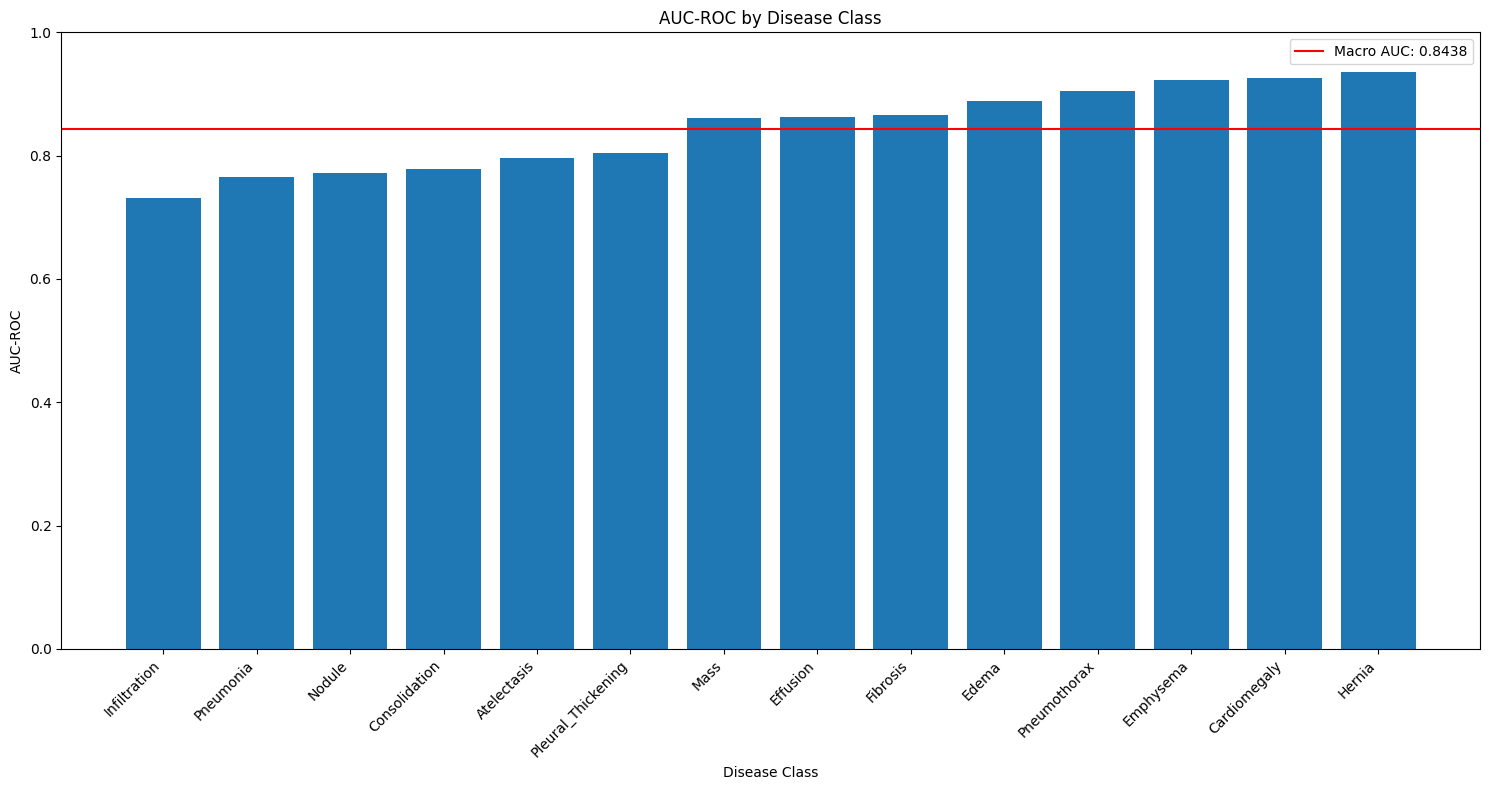

✅ AUC-ROC visualization saved to '/userHome/userhome4/kyoungmin/code/Xray/CTransCNN/result/error_analysis_ipynb_version/plots/ctranscnn_auc_by_class.png'

===== 분석 완료 =====
결과 저장 위치: /userHome/userhome4/kyoungmin/code/Xray/CTransCNN/result/error_analysis_ipynb_version


In [9]:
# 셀 9: AUC-ROC 시각화

# ROC-AUC 시각화
plt.figure(figsize=(15, 8))
sorted_aucs = sorted(class_aucs.items(), key=lambda x: x[1])
cls_names = [item[0] for item in sorted_aucs]
auc_values = [item[1] for item in sorted_aucs]

plt.bar(cls_names, auc_values)
macro_auc = np.nanmean(list(class_aucs.values()))
plt.axhline(y=macro_auc, color='r', linestyle='-', label=f'Macro AUC: {macro_auc:.4f}')
plt.xlabel('Disease Class')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC by Disease Class')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()

auc_plot_file = os.path.join(plots_dir, "ctranscnn_auc_by_class.png")
plt.savefig(auc_plot_file)
plt.show()

print(f"✅ AUC-ROC visualization saved to '{auc_plot_file}'")
print("\n===== 분석 완료 =====")
print(f"결과 저장 위치: {BASE_RESULT_DIR}")
